# ID5030 Assignment 5
#### P Akhil Reddy    
#### CH20B076

## Question 1)
### Implementing neural network with one hidden layer for classifying an XOR gate.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def sigmoid(z):
	# Returns sigmoid of z
	return 1 / (1 + np.exp(-z))

In [3]:
def initParams(inputs, hidden, outputs):
    # Initialises the weights and biases
    W1 = np.random.randn(hidden, inputs)
    b1 = np.zeros((hidden, 1))
    W2 = np.random.randn(outputs, hidden)
    b2 = np.zeros((outputs, 1))

    return (W1, b1, W2, b2)

def forwardPropagate(X, y_out, params):
    # Performs forward propagation for the neural network
    W1, b1, W2, b2 = params

    y1 = np.dot(W1, X) + b1
    y1_hat = sigmoid(y1)
    y2 = np.dot(W2, y1_hat) + b2
    y2_hat = sigmoid(y2)

    y_out_pred = y2_hat

    cost = (-1/(X.shape[1]))*np.sum(np.multiply(np.log(y2_hat), y_out) + np.multiply(np.log(1 - y2_hat), (1 - y_out)))

    backup = (y1, y1_hat, y2, y_out_pred)

    return cost, backup, params

def backPropagate(X, y_out, params, backup):
    # Performs backward propagation for the neural network
    y1, y1_hat, y2, y_out_pred = backup
    W1, b1, W2, b2 = params

    dy_out = y_out_pred - y_out
    dW2 = np.dot(dy_out, y1_hat.T)/X.shape[1]
    db2 = np.sum(dy_out, axis=1, keepdims=True)

    dy1_hat = np.dot(W2.T, dy_out)
    dy1 = np.multiply(dy1_hat, y1_hat*(1-y1_hat))
    dW1 = np.dot(dy1, X.T)/X.shape[1]
    db1 = np.sum(dy1, axis=1, keepdims=True)/X.shape[1]

    return (dy1_hat, dW1, db1, dy_out, dW2, db2)

def updateParameters(params, grads, lr):
    # Updates the parameters while training the model
    W1, b1, W2, b2 = params
    dy1_hat, dW1, db1, dy_out, dW2, db2 = grads

    W1 = W1 - lr*dW1
    b1 = b1 - lr*db1
    W2 = W2 - lr*dW2
    b2 = b2 - lr*db2

    return (W1, b1, W2, b2)

### Generating the dataset.

In [4]:
X = np.array([[0, 0, 1, 1], 
              [0, 1, 0, 1]])

y = np.array([[0, 1, 1, 0]])

#### Defining the hyperparameters of the algorithm.

In [5]:
# Defining the hyperparameters of the algorithm
hidden = 2
inputs = 2
outputs = 1


params = initParams(inputs, hidden, outputs)
epochs = 75000
lr = 0.01

### Training the model

In [6]:
losses = []

for i in range(epochs):
	cost, backup, params = forwardPropagate(X, y, params)
	losses.append(cost)
	grads = backPropagate(X, y, params, backup)
	params = updateParameters(params, grads, lr)

### Plotting losses vs epochs

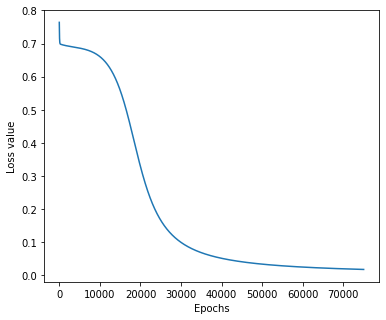

In [7]:
with mpl.rc_context({'figure.figsize': (6,5)}):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.show()

### Testing on the truth table.

In [8]:
cost, backup, params = forwardPropagate(X, y, params)

y_out_pred = backup[3]

y_pred = (y_out_pred > 0.5)*1
y_pred

array([[0, 1, 1, 0]])

### We see that the predictions are accurate.

## Question 2)

### a) Implementing single layer neural network for regression. Writing backpropagation function for an arbitrary number of neurons in hidden layer.

In [9]:
# loading the data from the excel file
df = pd.read_excel('Concrete_Data.xls')
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [10]:
# Separating the input and output data and standardising the input data
X = df.iloc[:, :-1].values
X = (X - X.mean()) / X.std()

y = df.iloc[:, -1].values.reshape(-1, 1)

# Input and output sizes
input_size = X.shape[1]
output_size = 1

In [11]:
def tanh(x):
    # Hyperbolic tangent function, used as activation function
    return np.tanh(x)

def tanh_grad(x):
    # Derivative of tanh function
    return 1 - np.tanh(x)**2

def mse_loss(y, y_pred):
    return np.mean((y - y_pred)**2)

In [12]:
def Train_and_Test_NN(hidden_size, lr, epochs, plot=False, show_errors=False):
    np.random.seed(42)
    
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros((1, output_size))

    losses = []

    for epoch in range(epochs):
        # Forward Propagation
        y1 = np.dot(X, W1) + b1
        g1 = tanh(y1)
        y2 = np.dot(g1, W2) + b2
        y_pred = y2

        # Calculating loss
        loss = mse_loss(y, y_pred)
        losses.append(loss)

        # Backpropagation
        dy2 = y_pred - y
        dW2 = np.dot(g1.T, dy2)
        db2 = np.sum(dy2, axis=0, keepdims=True)
        dy1 = np.dot(dy2, W2.T) * tanh_grad(y1)
        dW1 = np.dot(X.T, dy1)
        db1 = np.sum(dy1, axis=0, keepdims=True)

        # Updating the weights
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1

        if (epoch % 100 == 0 and show_errors):
            print(f'MSE loss at epoch {epoch}: {loss}')

    if(plot):
        #Plotting the losses for train data 
        plt.plot(losses)
        plt.title("MSE while training")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Squared Error")
        plt.show()

    return losses


In [13]:
losses1 = Train_and_Test_NN(5, 1e-5, 500)
losses2 = Train_and_Test_NN(6, 1e-5, 500)
losses3 = Train_and_Test_NN(7, 1e-5, 500)
losses4 = Train_and_Test_NN(8, 1e-5, 500)
losses5 = Train_and_Test_NN(9, 1e-5, 500)

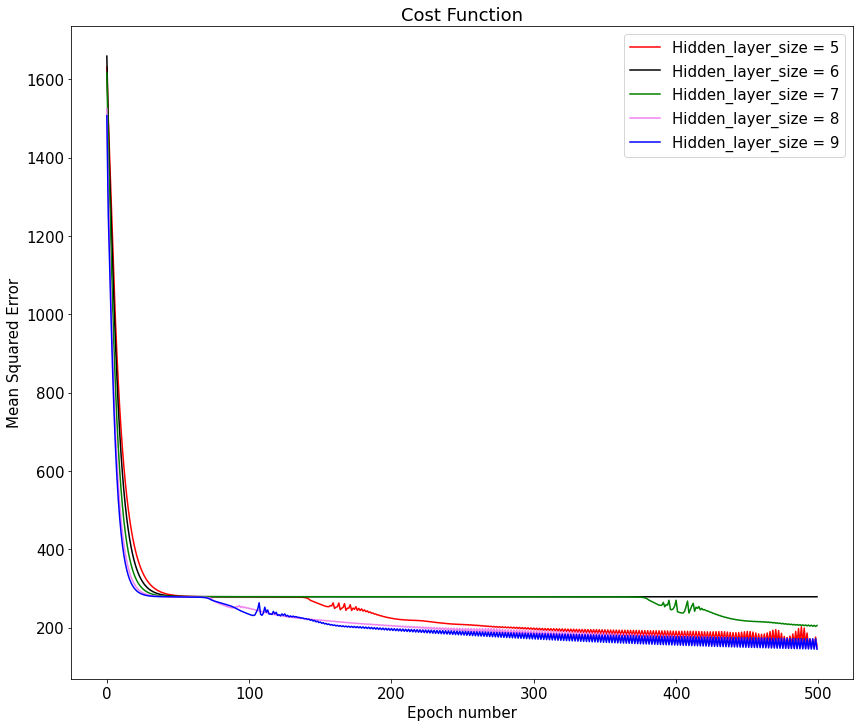

In [14]:
with mpl.rc_context({'figure.figsize': (14,12), 'font.size': 15}):
    fig, ax = plt.subplots()
    ax.plot(np.arange(500), losses1, color = 'red')
    ax.plot(np.arange(500), losses2, color = 'black')
    ax.plot(np.arange(500), losses3, color = 'green')
    ax.plot(np.arange(500), losses4, color = 'violet')
    ax.plot(np.arange(500), losses5, color = 'blue')

    ax.set_title('Cost Function')
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Mean Squared Error');
    ax.legend(['Hidden_layer_size = 5', 'Hidden_layer_size = 6', 'Hidden_layer_size = 7','Hidden_layer_size = 8','Hidden_layer_size = 9']);

### Now the same function will be implemented in PyTorch as well.

In [15]:
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

In [16]:
def Train_and_Test_TorchNN(hidden_size, lr, epochs, plot=False, show_errors=False):
    torch.manual_seed(42)

    # Defining the model architecture
    class NeuralNet(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(NeuralNet, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            x = torch.tanh(self.fc1(x))
            x = self.fc2(x)
            return x
        
    net = NeuralNet(input_size, hidden_size, output_size)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr)

    losses = []

    # Training the model
    for epoch in range(epochs):
        # Forward propagation
        y_pred = net(X_torch)
        
        # Computing the loss
        loss = criterion(y_pred, y_torch)
        losses.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Updating the weights
        optimizer.step()
        
        # Print the loss every n epochs
        if ((epoch+1) % 500 == 0 and show_errors):
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Plot the train losses
    if(plot):
        plt.plot(losses)
        plt.title("Loss during training")
        plt.xlabel("Epoch")
        plt.ylabel("Mean squared error")
        plt.show()

    return losses

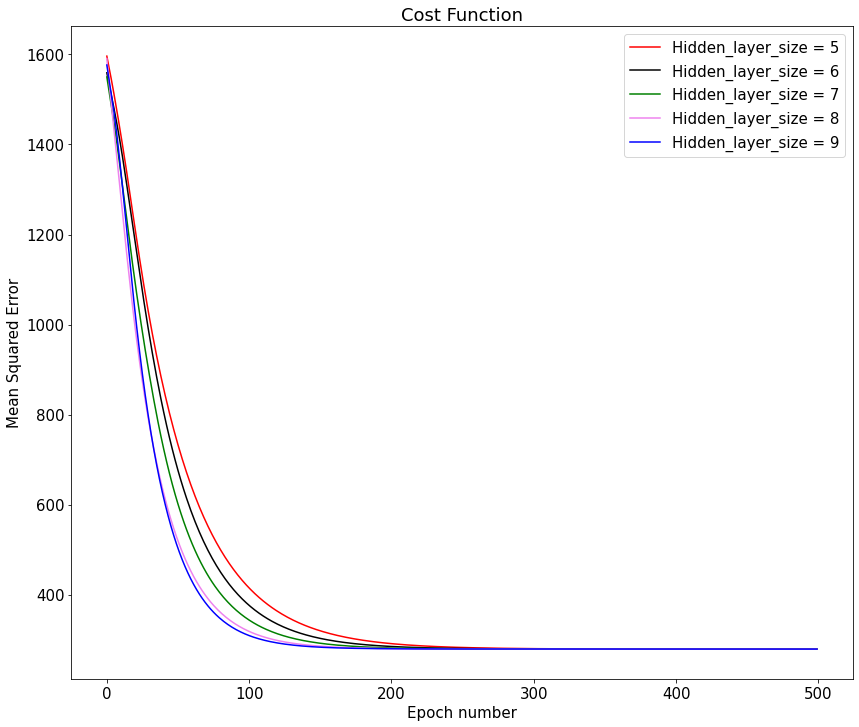

In [17]:
losses1 = Train_and_Test_TorchNN(5, 1e-3, 500)
losses2 = Train_and_Test_TorchNN(6, 1e-3, 500)
losses3 = Train_and_Test_TorchNN(7, 1e-3, 500)
losses4 = Train_and_Test_TorchNN(8, 1e-3, 500)
losses5 = Train_and_Test_TorchNN(9, 1e-3, 500)

with mpl.rc_context({'figure.figsize': (14,12), 'font.size': 15}):
    fig, ax = plt.subplots()
    ax.plot(np.arange(500), losses1, color = 'red')
    ax.plot(np.arange(500), losses2, color = 'black')
    ax.plot(np.arange(500), losses3, color = 'green')
    ax.plot(np.arange(500), losses4, color = 'violet')
    ax.plot(np.arange(500), losses5, color = 'blue')

    ax.set_title('Cost Function')
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Mean Squared Error');
    ax.legend(['Hidden_layer_size = 5', 'Hidden_layer_size = 6', 'Hidden_layer_size = 7','Hidden_layer_size = 8','Hidden_layer_size = 9']);

### From the plots we can infer that the PyTorch code takes slightly more number of epochs than the vanilla python code for converging to the optimal solution. But the PyTorch implementation is more stable and less oscillatory.

### b) Performing a 60-20-20 split on the dataset and performing hyperparameter tuning, to find the optimal number of neurons.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [19]:
def Train_and_Test_NN2(hidden_size, lr, epochs, plot=False, show_errors=False, show_train_error=False, show_r2=False):
    np.random.seed(42)
    
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros((1, output_size))

    losses = []

    for epoch in range(epochs):
        # Forward Propagation
        y1 = np.dot(X_train, W1) + b1
        g1 = tanh(y1)
        y2 = np.dot(g1, W2) + b2
        y_pred = y2

        # Calculating loss
        loss = mse_loss(y_train, y_pred)
        losses.append(loss)

        # Backpropagation
        dy2 = y_pred - y_train
        dW2 = np.dot(g1.T, dy2)
        db2 = np.sum(dy2, axis=0, keepdims=True)
        dy1 = np.dot(dy2, W2.T) * tanh_grad(y1)
        dW1 = np.dot(X_train.T, dy1)
        db1 = np.sum(dy1, axis=0, keepdims=True)

        # Updating the weights
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1

        if (epoch % 100 == 0 and show_errors):
            print(f'MSE loss at epoch {epoch}: {loss}')

    y1 = np.dot(X_train, W1) + b1
    g1 = tanh(y1)
    y2 = np.dot(g1, W2) + b2
    y_train_pred = y2

    train_loss = mse_loss(y_train, y_train_pred)

    if(show_train_error):
        print(f"Loss on train set with {hidden_size} neurons in the hidden layer: {loss:.4f}")

        if(show_r2):
            print(f"r2 score on train dataset with {hidden_size} neurons in the hidden layer: {r2_score(y_train, y_train_pred)}\n")

    # Performing forward propagation on the validation dataset
    y1 = np.dot(X_val, W1) + b1
    g1 = tanh(y1)
    y2 = np.dot(g1, W2) + b2
    y_val_pred = y2

    val_loss = mse_loss(y_val, y_val_pred)
    print(f"Loss on validation set with {hidden_size} neurons in the hidden layer: {val_loss:.4f}")

    if(show_r2):
        print(f"r2 score on train dataset with {hidden_size} neurons in the hidden layer: {r2_score(y_val, y_val_pred)}\n")

    # Performing forward propagation on the test dataset
    y1 = np.dot(X_test, W1) + b1
    g1 = tanh(y1)
    y2 = np.dot(g1, W2) + b2
    y_test_pred = y2

    test_loss = mse_loss(y_test, y_test_pred)
    print(f"Loss on test set with {hidden_size} neurons in the hidden layer: {test_loss:.4f}")

    if(show_r2):
        print(f"r2 score on train dataset with {hidden_size} neurons in the hidden layer: {r2_score(y_test, y_test_pred)}\n")

    print('\n')

    if(plot):
        #Plotting the losses for train data 
        plt.plot(losses)
        plt.title("MSE while training")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Squared Error")
        plt.show()

    return losses


### Now we will try different values of hidden layer neuron count, and try the find the one which gives lowest validation error.
### First we will search from 4 to 10.

In [20]:
losses1 = Train_and_Test_NN2(4, 1e-5, 10000)
losses2 = Train_and_Test_NN2(5, 1e-5, 10000)
losses3 = Train_and_Test_NN2(6, 1e-5, 10000)
losses4 = Train_and_Test_NN2(7, 1e-5, 10000)
losses5 = Train_and_Test_NN2(8, 1e-5, 10000)
losses6 = Train_and_Test_NN2(9, 1e-5, 10000)
losses7 = Train_and_Test_NN2(10, 1e-5, 10000)

Loss on validation set with 4 neurons in the hidden layer: 122.7751
Loss on test set with 4 neurons in the hidden layer: 120.9659


Loss on validation set with 5 neurons in the hidden layer: 88.9313
Loss on test set with 5 neurons in the hidden layer: 92.5014


Loss on validation set with 6 neurons in the hidden layer: 111.0352
Loss on test set with 6 neurons in the hidden layer: 93.1231


Loss on validation set with 7 neurons in the hidden layer: 122.9961
Loss on test set with 7 neurons in the hidden layer: 121.1476


Loss on validation set with 8 neurons in the hidden layer: 70.1704
Loss on test set with 8 neurons in the hidden layer: 59.6988


Loss on validation set with 9 neurons in the hidden layer: 70.0428
Loss on test set with 9 neurons in the hidden layer: 66.4291


Loss on validation set with 10 neurons in the hidden layer: 77.2483
Loss on test set with 10 neurons in the hidden layer: 84.6680




### Then we will search till 100 hidden layer neurons.

In [23]:
losses8 = Train_and_Test_NN2(15, 1e-5, 10000)
losses9 = Train_and_Test_NN2(20, 1e-5, 10000)
losses10 = Train_and_Test_NN2(30, 1e-5, 10000)
losses11 = Train_and_Test_NN2(50, 1e-5, 10000)
losses12 = Train_and_Test_NN2(100, 1e-5, 10000)

Loss on validation set with 15 neurons in the hidden layer: 74.9833
Loss on test set with 15 neurons in the hidden layer: 83.6341


Loss on validation set with 20 neurons in the hidden layer: 67.3095
Loss on test set with 20 neurons in the hidden layer: 62.6398


Loss on validation set with 30 neurons in the hidden layer: 51.6173
Loss on test set with 30 neurons in the hidden layer: 55.1567


Loss on validation set with 50 neurons in the hidden layer: 51.0749
Loss on test set with 50 neurons in the hidden layer: 56.2666


Loss on validation set with 100 neurons in the hidden layer: 56.6354
Loss on test set with 100 neurons in the hidden layer: 49.7942




### We infer that the optimal number of neurons must be around 50.

In [29]:
losses22 = Train_and_Test_NN2(47, 1e-5, 10000)
losses23 = Train_and_Test_NN2(48, 1e-5, 10000)
losses24 = Train_and_Test_NN2(49, 1e-5, 10000)
losses25 = Train_and_Test_NN2(50, 1e-5, 10000)
losses26 = Train_and_Test_NN2(51, 1e-5, 10000)
losses27 = Train_and_Test_NN2(52, 1e-5, 10000)

Loss on validation set with 47 neurons in the hidden layer: 53.5784
Loss on test set with 47 neurons in the hidden layer: 58.3823


Loss on validation set with 48 neurons in the hidden layer: 52.6479
Loss on test set with 48 neurons in the hidden layer: 58.4543


Loss on validation set with 49 neurons in the hidden layer: 54.5321
Loss on test set with 49 neurons in the hidden layer: 51.3391


Loss on validation set with 50 neurons in the hidden layer: 51.0749
Loss on test set with 50 neurons in the hidden layer: 56.2666


Loss on validation set with 51 neurons in the hidden layer: 55.1572
Loss on test set with 51 neurons in the hidden layer: 49.9223


Loss on validation set with 52 neurons in the hidden layer: 52.1896
Loss on test set with 52 neurons in the hidden layer: 56.6830




### From the different values of validation errors, we observe that the neural network with 50 neurons in the hidden layer has the lowest validation error. `Therefore the optimal number of neurons in the hidden layer is 50.`

### Now we will train the neural network with 50 hidden layer neurons.

In [30]:
losses = Train_and_Test_NN2(50, 1e-5, 50000, show_train_error=True, show_r2=True)

Loss on train set with 50 neurons in the hidden layer: 21.2418
r2 score on train dataset with 50 neurons in the hidden layer: 0.9240514361219239

Loss on validation set with 50 neurons in the hidden layer: 33.7719
r2 score on train dataset with 50 neurons in the hidden layer: 0.889243894030625

Loss on test set with 50 neurons in the hidden layer: 40.2264
r2 score on train dataset with 50 neurons in the hidden layer: 0.8438905783308528





### c) Results of Linear and Quadratic Regressions taken from Assignments 1 and 2:

### With only linear features:
Mean squared error of the model on the train dataset: 107.25842311011506    
r-squared value of the model on the train dataset: 0.6196006621677799

Mean squared error of the model on the test dataset: 109.75614063734939    
r-squared value of the model on the test dataset: 0.5943642890037375

### With quadratic features:
Mean squared error of the model on the train dataset: 51.599771287198465    
r-squared value of the model on the train dataset: 0.8169978798793918

Mean squared error of the model on the test dataset: 60.041133169083835    
r-squared value of the model on the test dataset: 0.7781005454397802

### On the other hand, the neural network with 50 hidden layers is able to achieve the following on the same dataset, for 50000 epochs.
Loss on train set with 50 neurons in the hidden layer: 21.2418    
r-squared value on train dataset with 50 neurons in the hidden layer: 0.9240514361219239    

Loss on validation set with 50 neurons in the hidden layer: 33.7719    
r-squared value on train dataset with 50 neurons in the hidden layer: 0.889243894030625    

Loss on test set with 50 neurons in the hidden layer: 40.2264    
r-squared value on train dataset with 50 neurons in the hidden layer: 0.8438905783308528  

### We infer that our optimal neural network has performed much better than the linear and quadratic regressions.